## 1. 翻译后的JSP存储位置
----

如下图, 是jsp翻译成java代码之后存储的位置, 


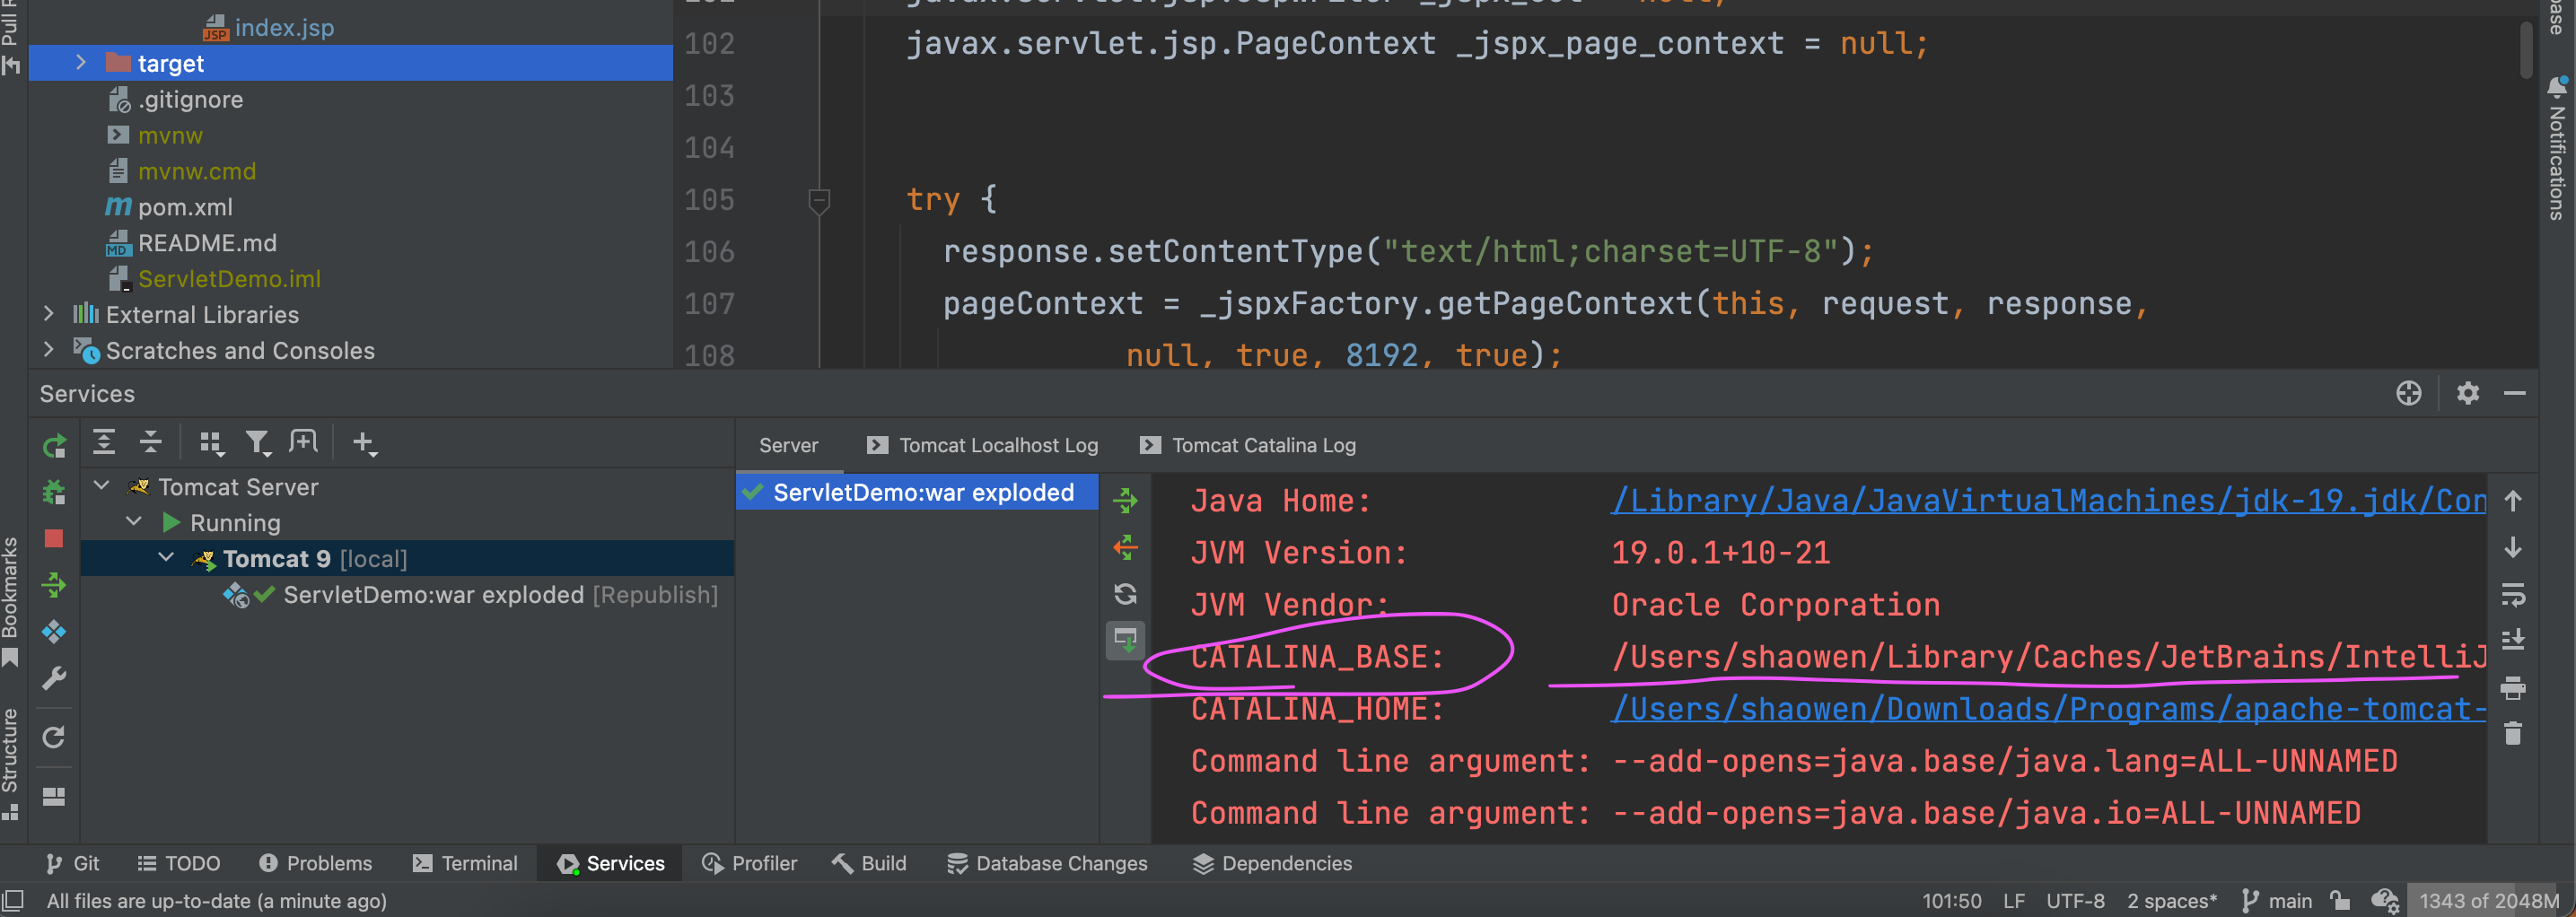

```shell
pwd
/Users/shaowen/Library/Caches/JetBrains/IntelliJIdea2022.1/tomcat/ef05aab2/work/Catalina/localhost/ROOT/org/apache/jsp

ls
index_jsp.class index_jsp.java
```

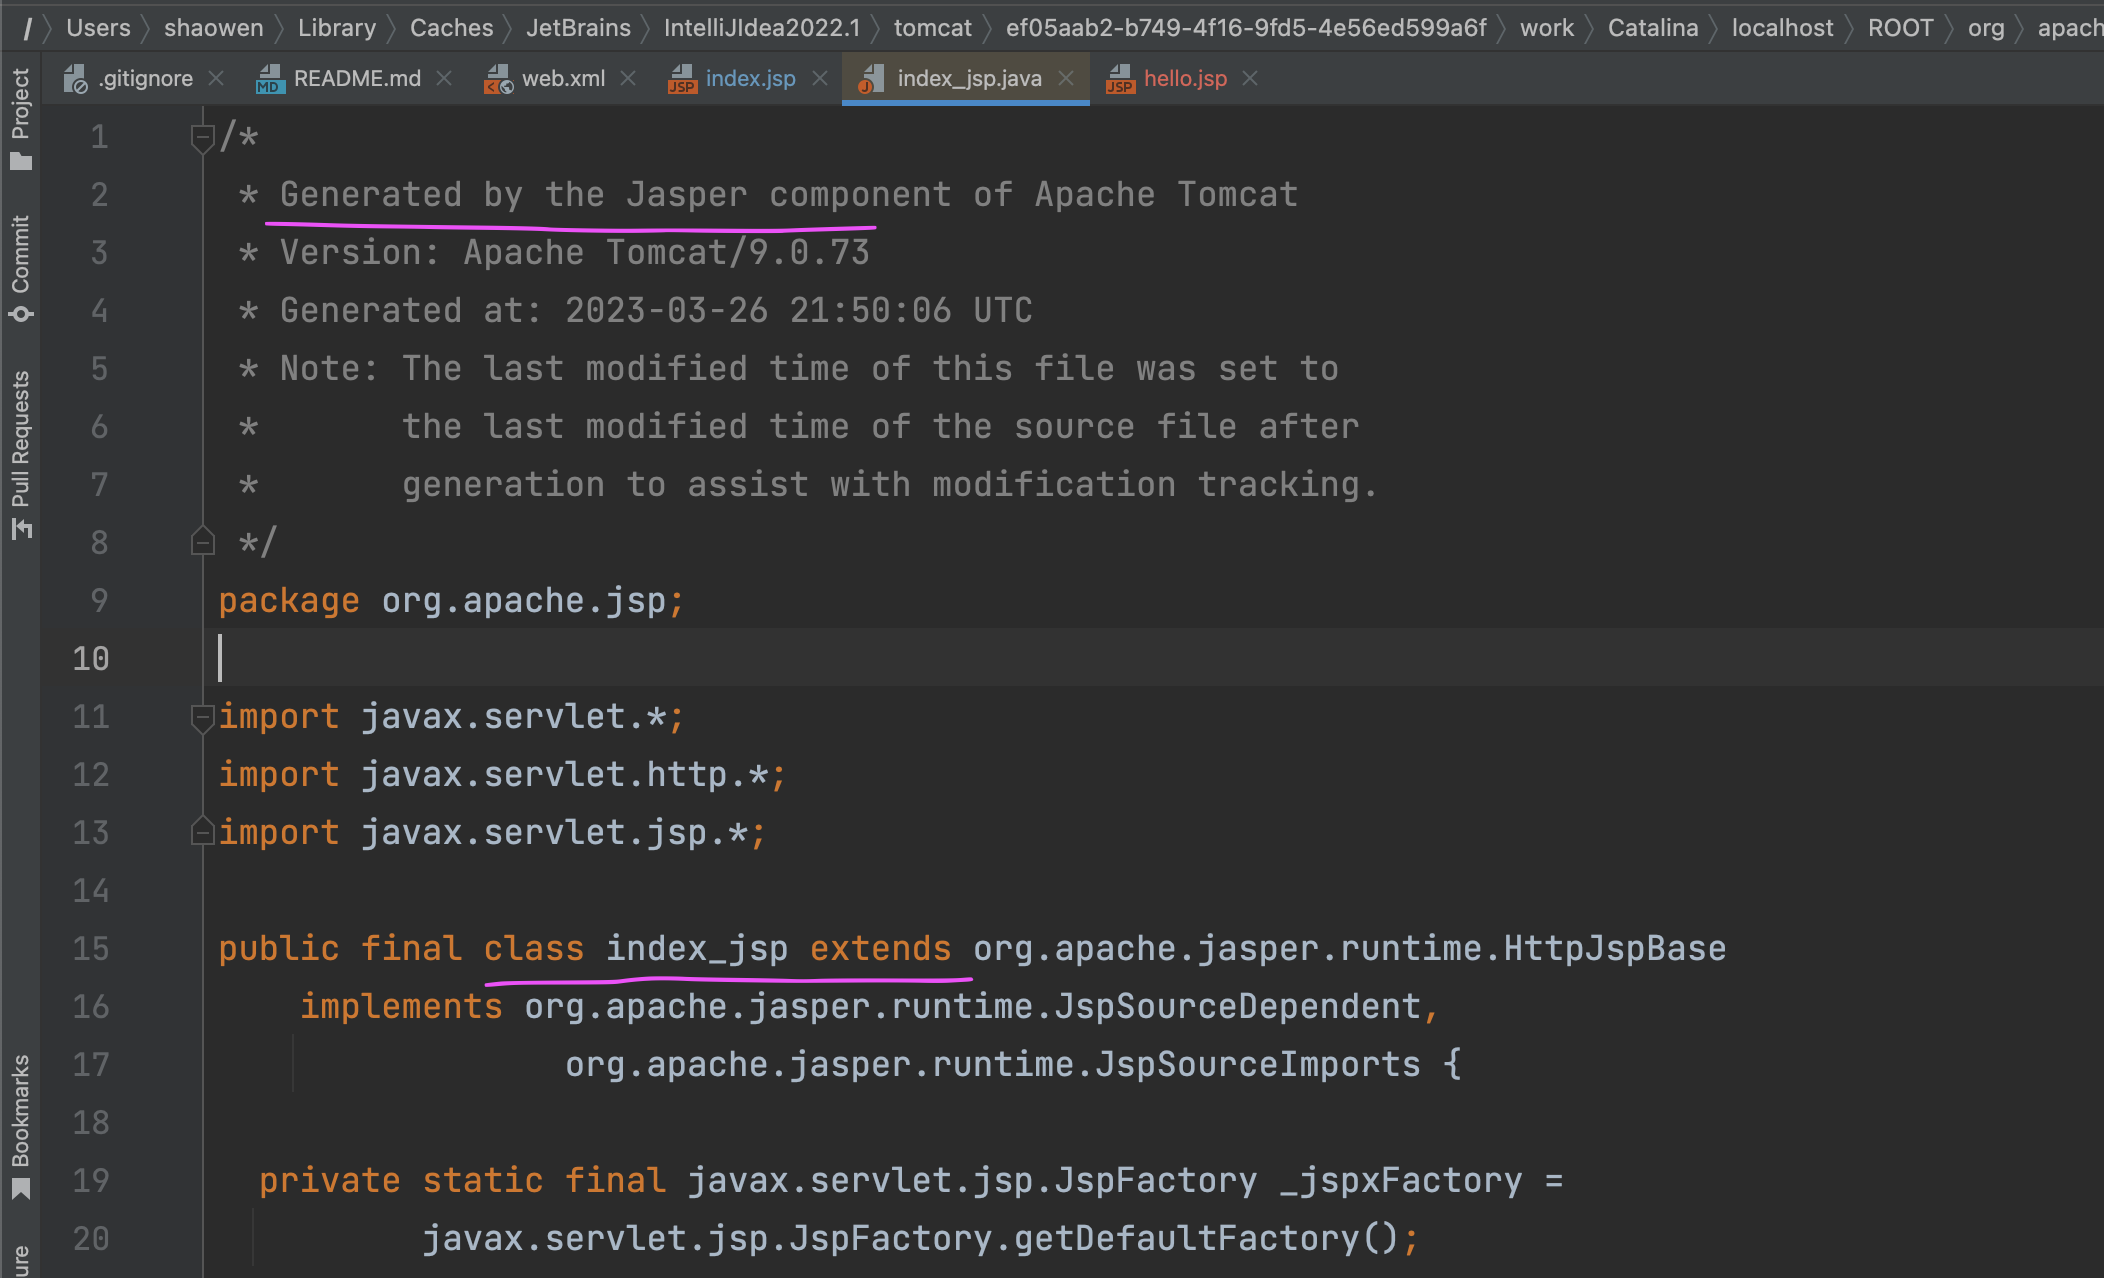

## 2. Servlet & JSP Engine
---

A Web Container (for example Apache Tomcat) has two different engines - called Catalina and Jasper. **Catalina** is a Servlet Engine and **Jasper** is a JSP Engine.

A JSP page is identified with its file name extension - `.jsp`, and has got two different phases.

JSP and Servlet has 3 different life cycle methods - `init()`, `service()` and `destroy()`. `Init()` and `destroy()` are called **only once** during the initial and final phase of execution whereas the `service()` method is called **repeatedly** for every request of the same JSP page / Servlet.

A JSP page is identified by its file name extension - `.jsp` and it is loaded by the **Jasper Engine** which gets that convered into a Servlet. In Tomcat you have a directory called 'work' inside 'webapps' folder of the Tomcat installation directory. It is the temporary area where the converted Servlet (which is a .class file) resides, to be picked up by Tomcat at runtime for every invocation of a JSP page. https://qr.ae/przqSy

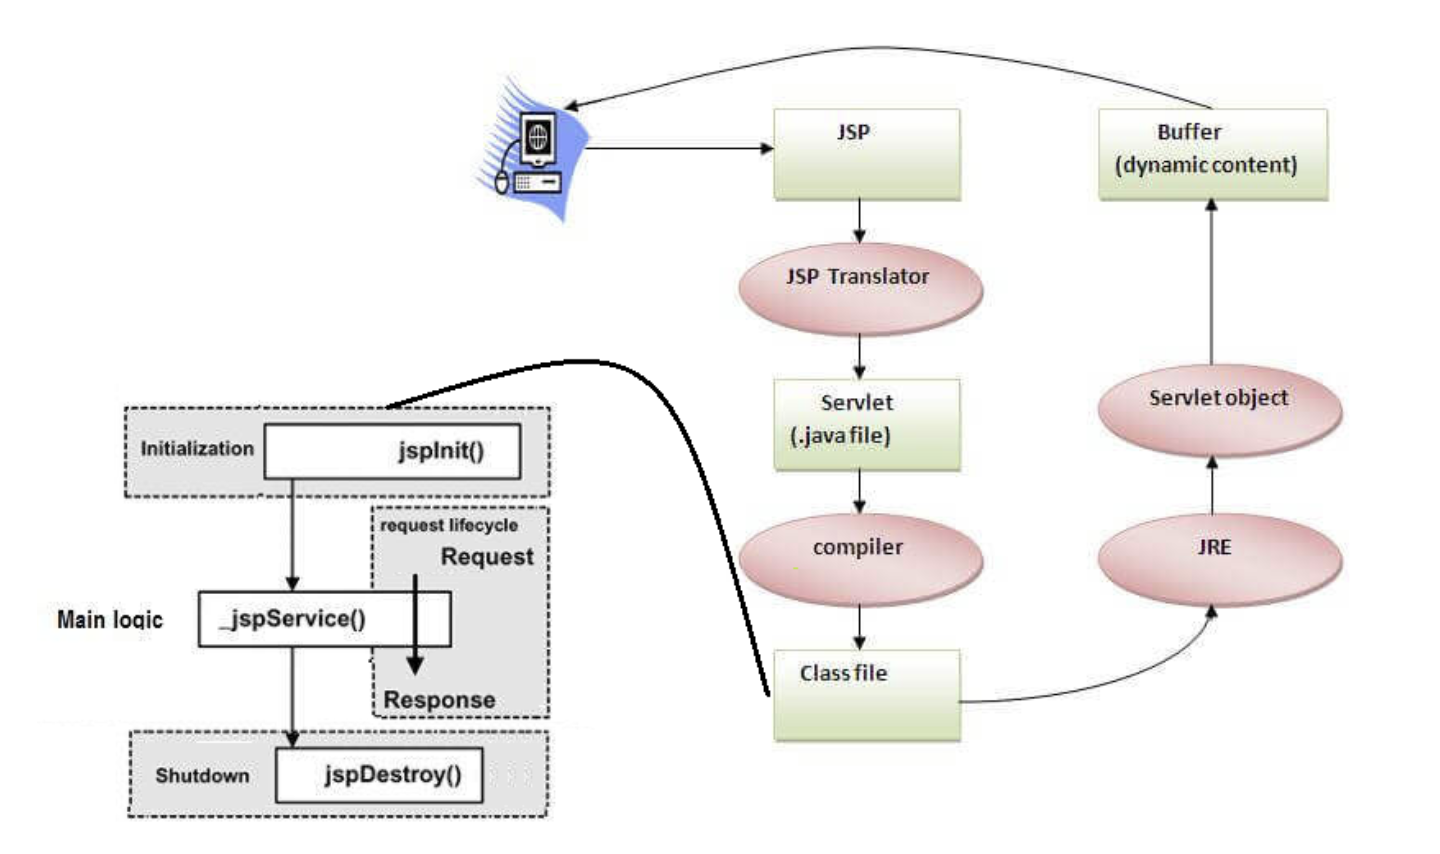

## 3. 源码分析
---

注意看翻译之后的jsp类的继承结构
```java
public final class index_jsp extends org.apache.jasper.runtime.HttpJspBase
    implements org.apache.jasper.runtime.JspSourceDependent,
                 org.apache.jasper.runtime.JspSourceImports {
                 ....
}
```

继承的是HttpJspBase, 注意这个类不属于Java EE, 而是apache自己实现的, 怎么实现的呢? 肯定是根据Java EE标准来实现的, Java EE只是定义了J几个interface和jsp相关, 并说明了这些interface的方法的具体行为, 具体实现就留给了像apache这样的web container厂商, 所以你明白为什么说JSP其实是servlet了吧, 翻译后的JSP继承自apache的servlet类, 而apache的servlet继承自Java EE的HttpServlet:

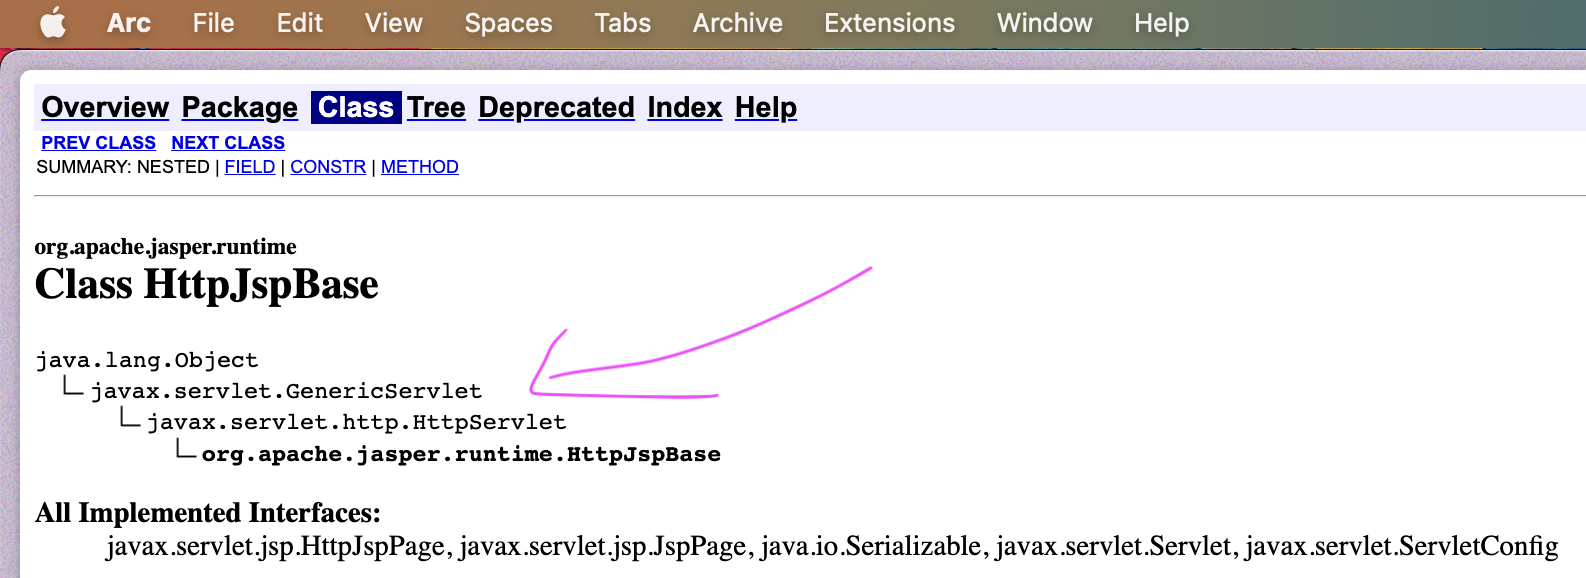

主要就三个方法 `_jspInit()`, `_jspService`, `_jspDestroy()`, 看看`_jspService()`都做了什么(开始做了一些看不懂的初始化, 然后判断一下 request的方法是get还是什么, 然后就返回页面(需要tomcat进一步处理成html)), 复杂的咱也看不懂:

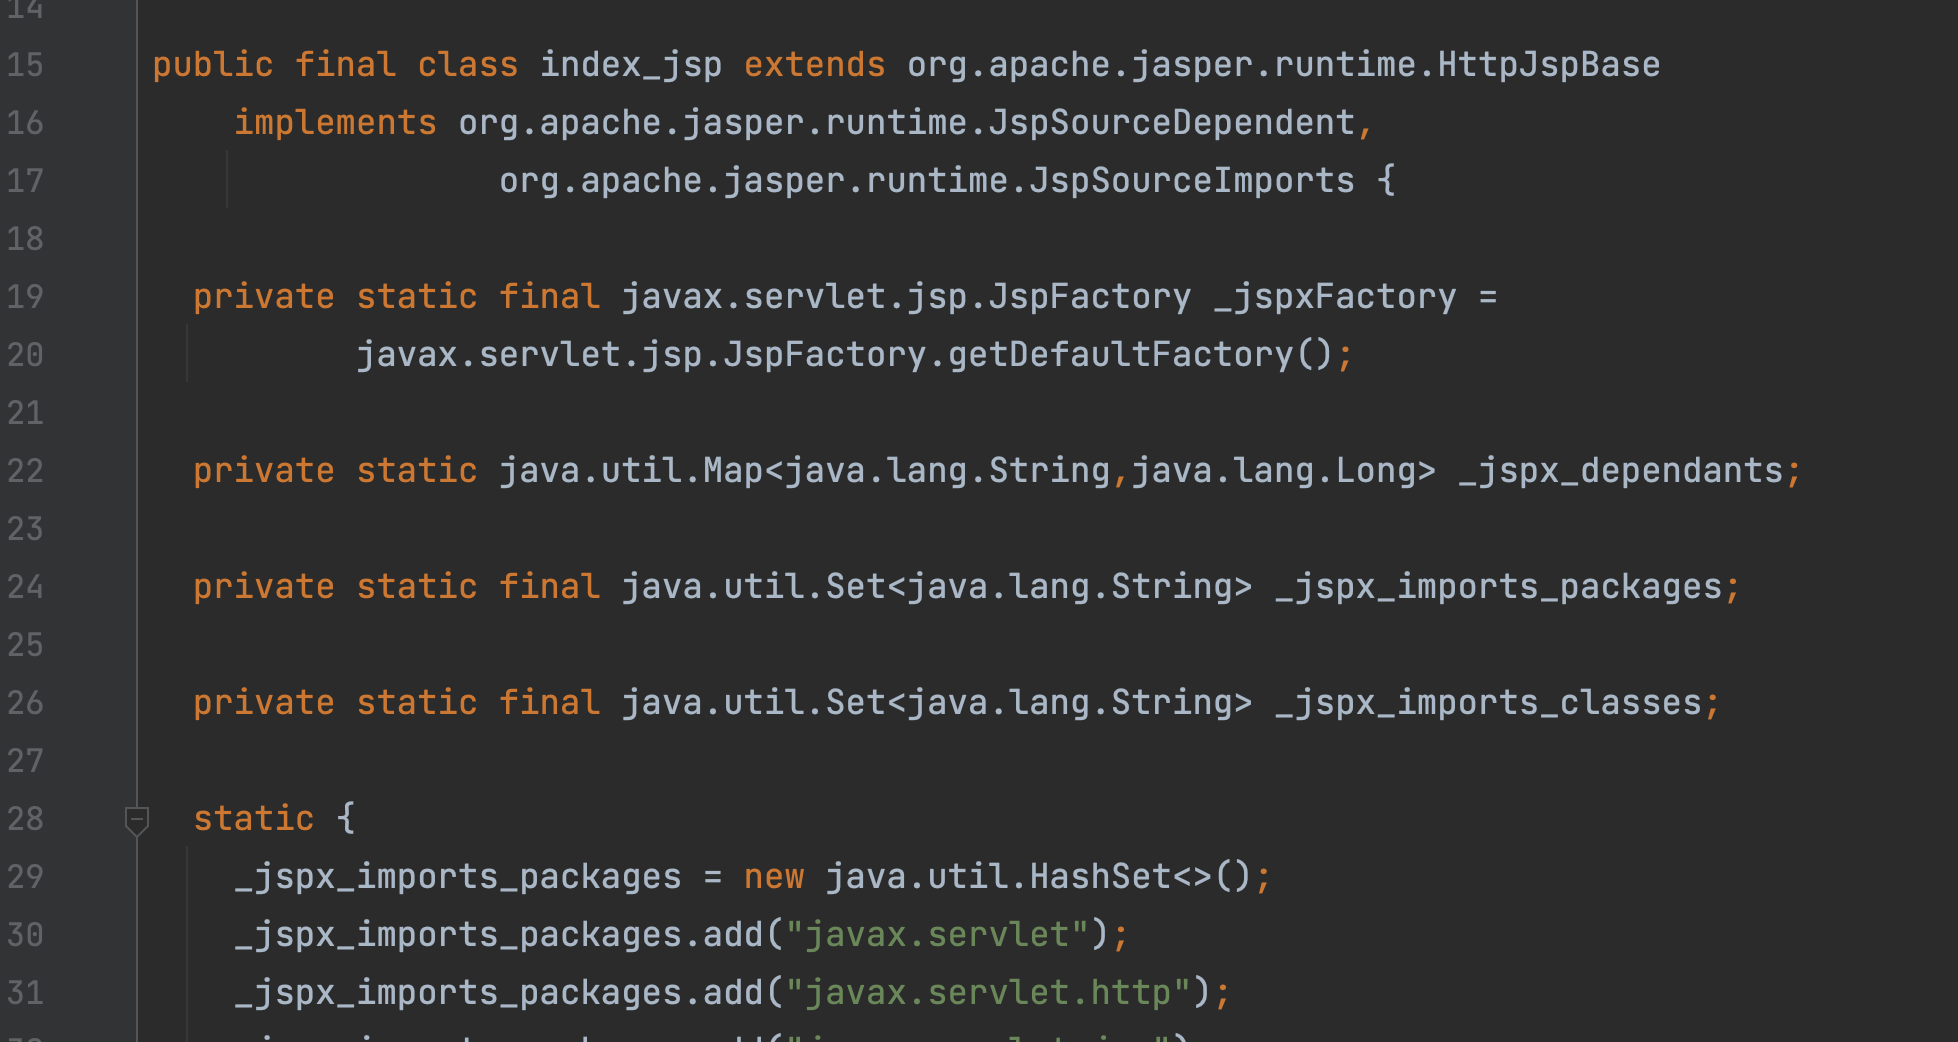

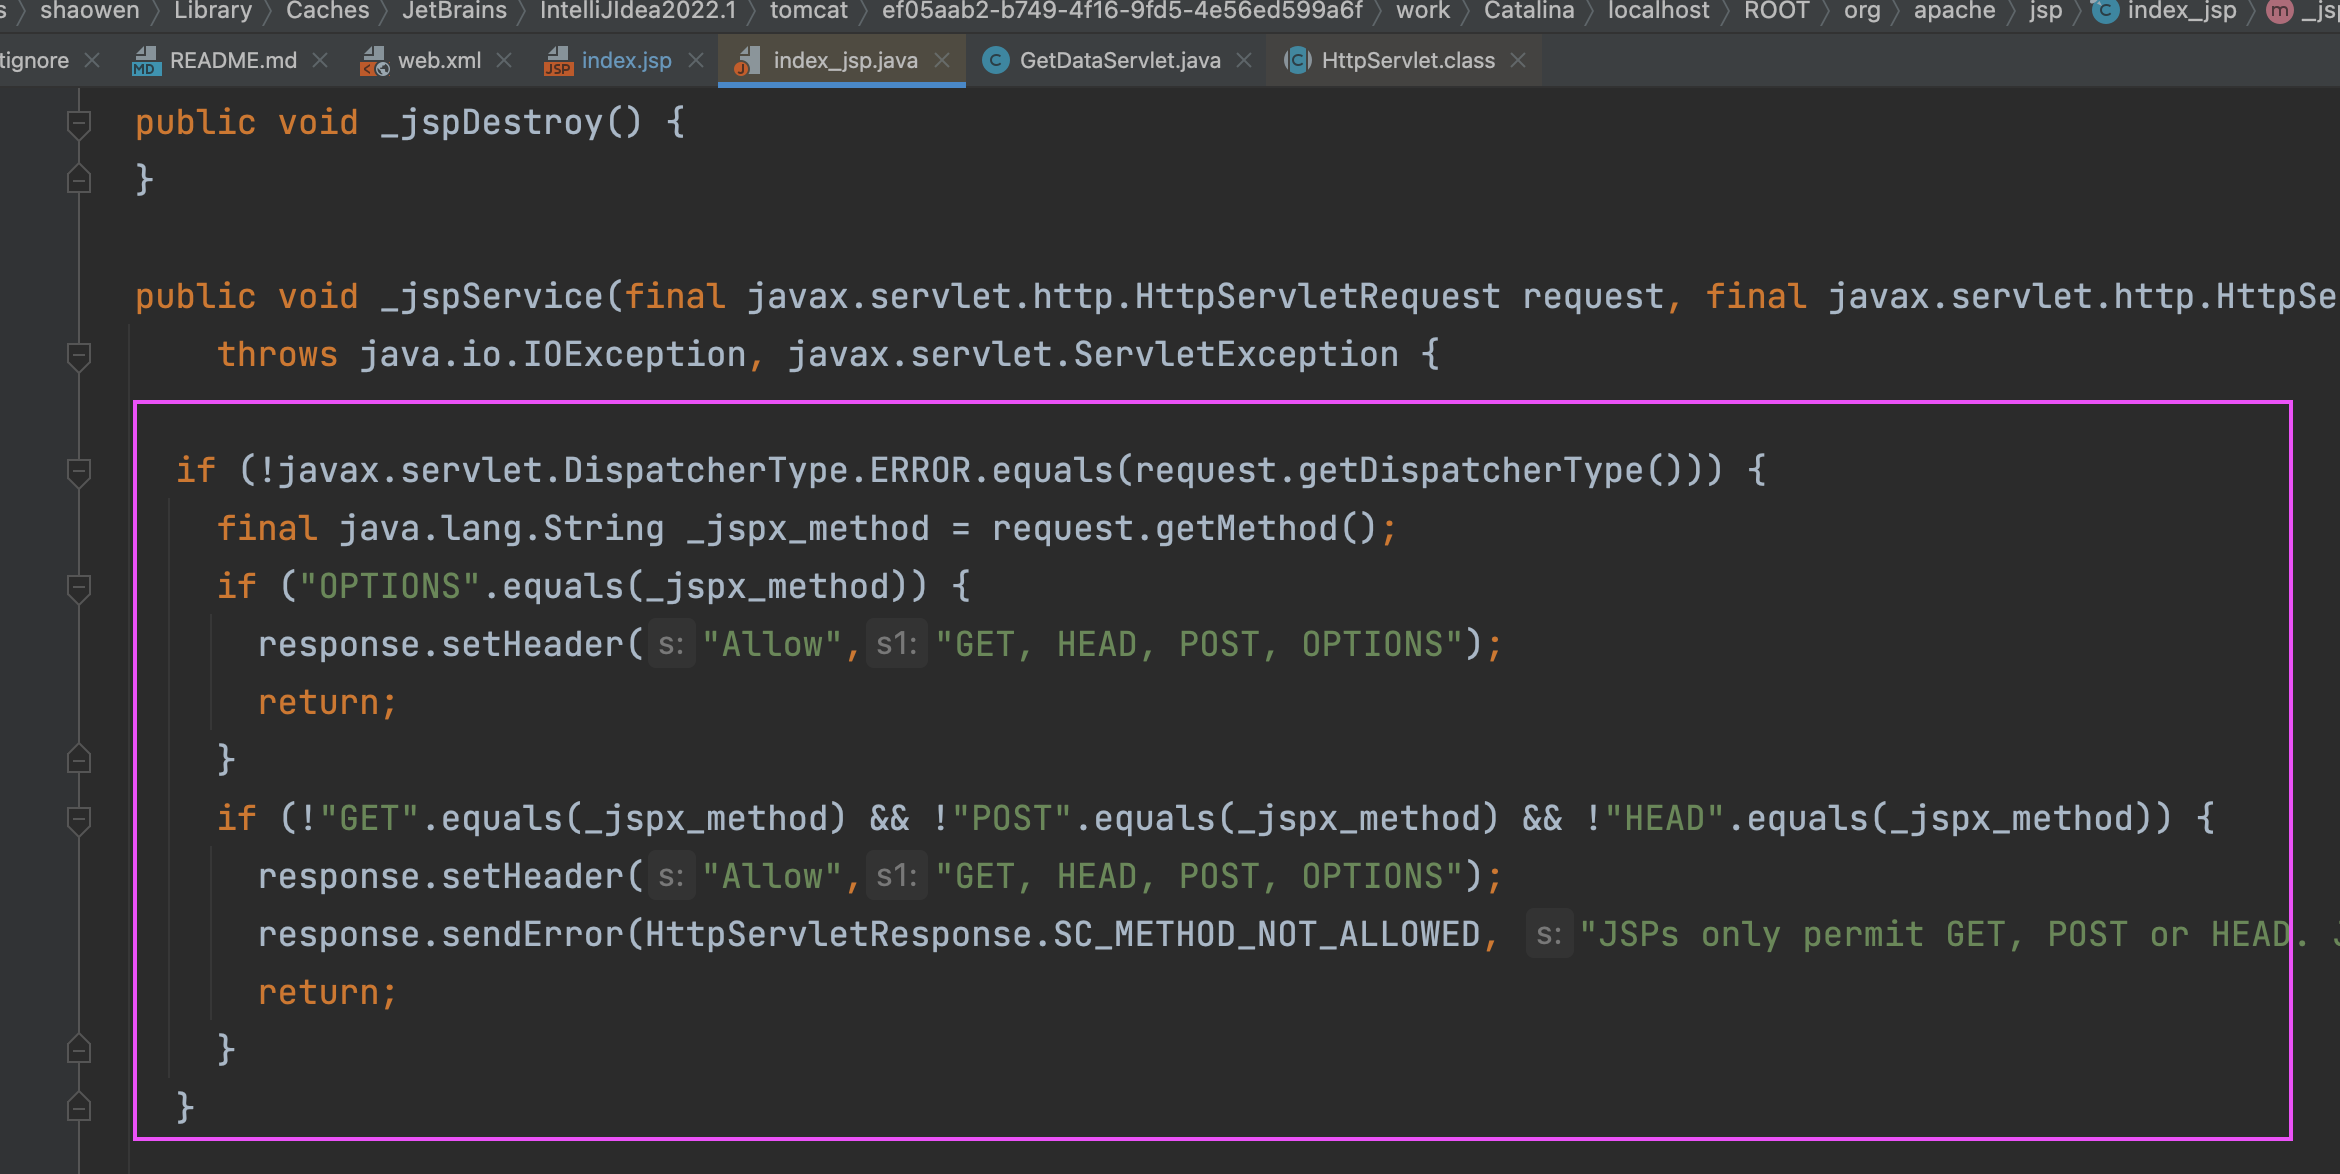

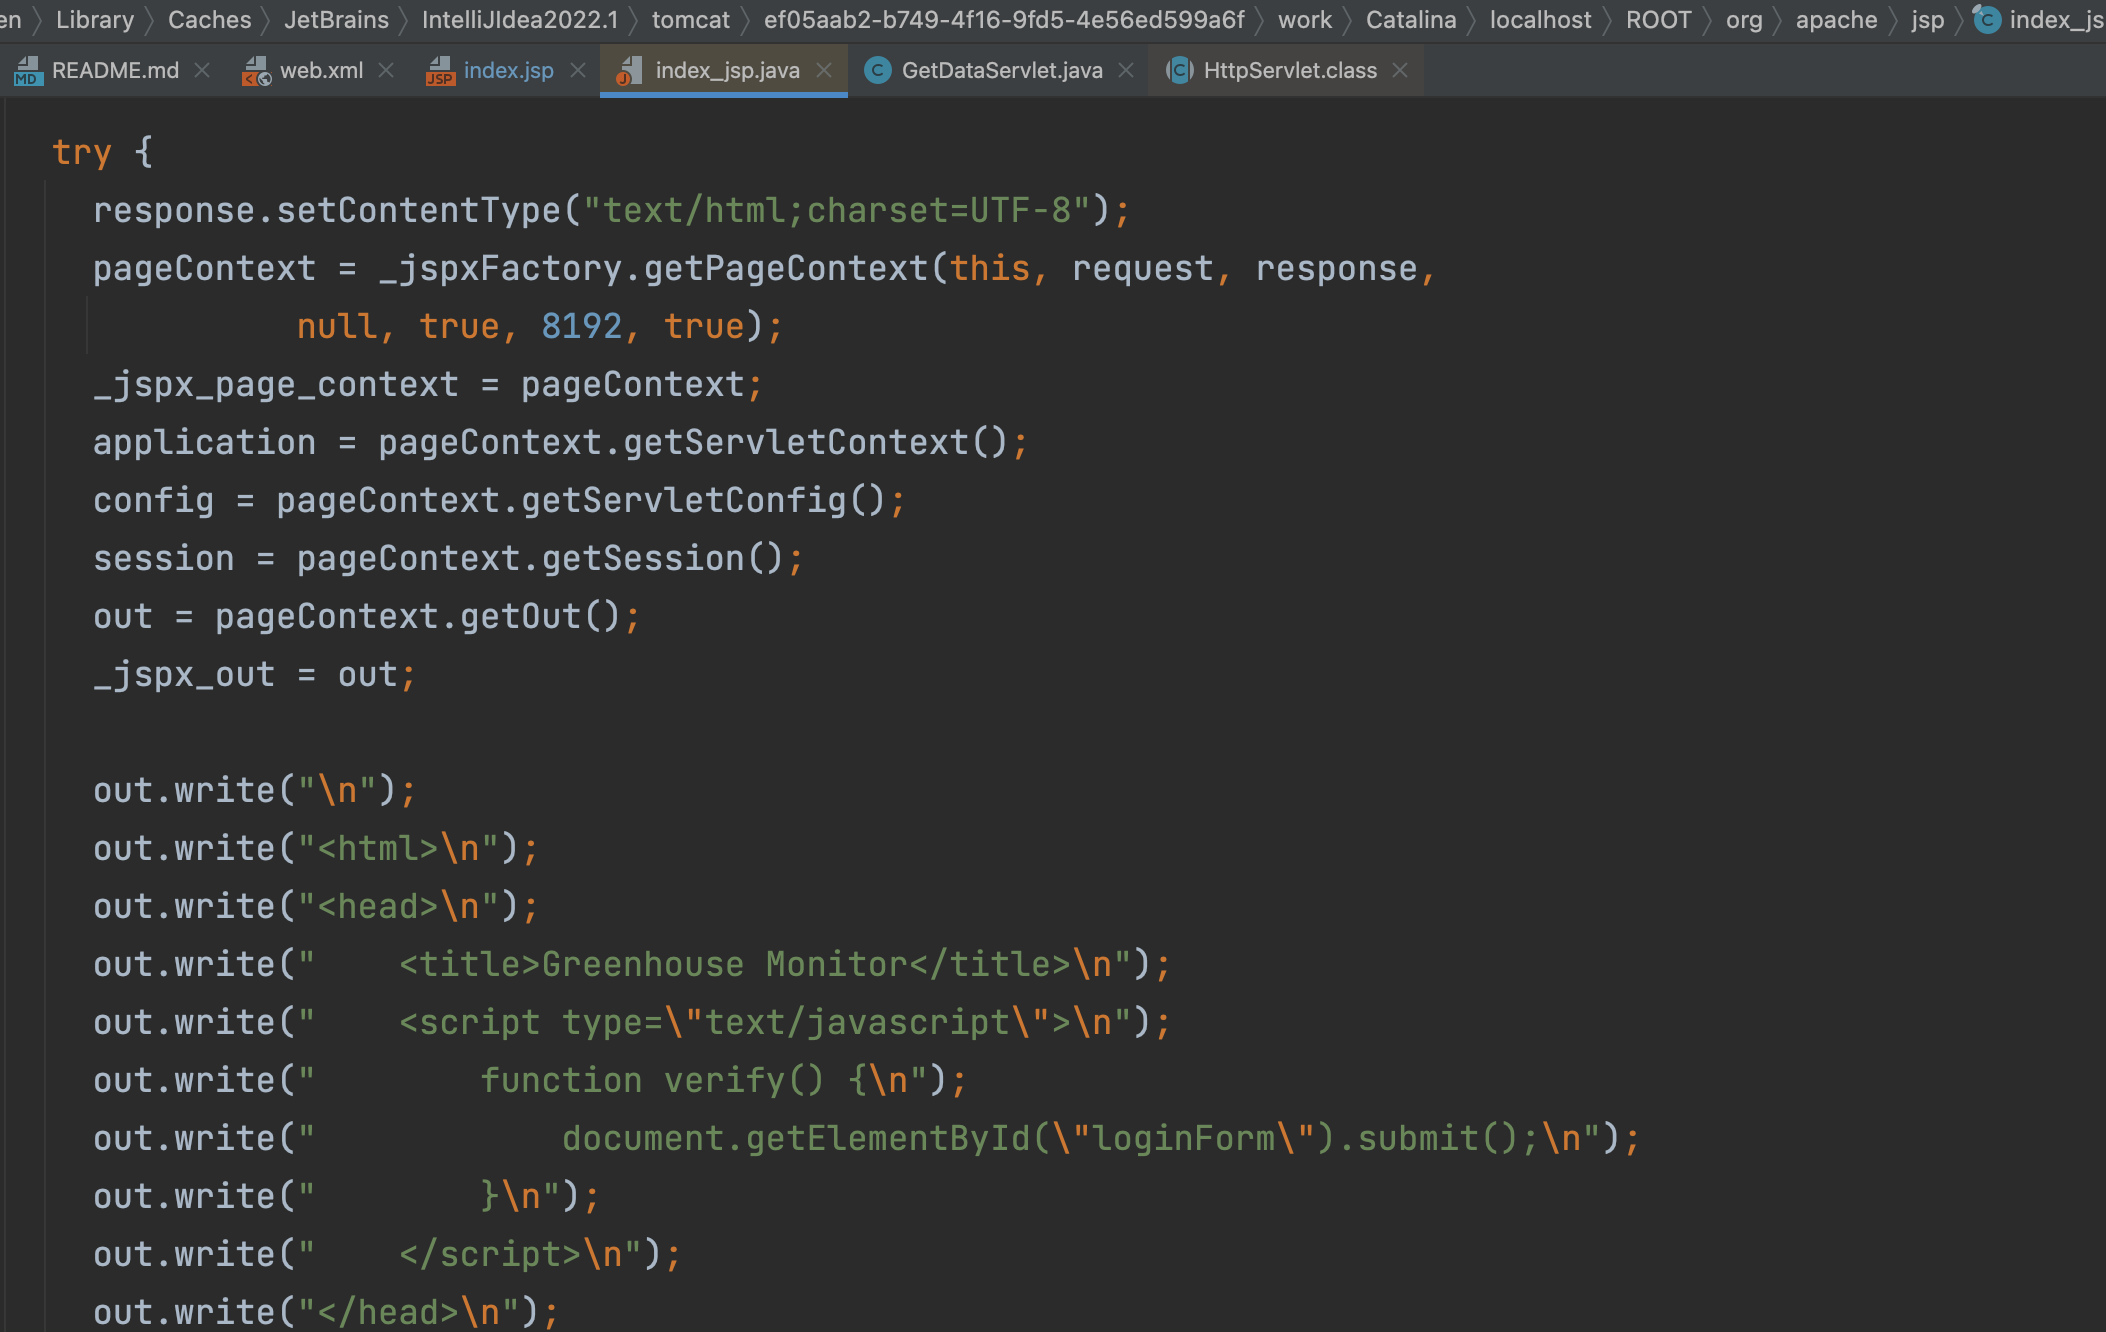

## 4. 一些思考
---

一直在思考JSP和Servlet的关系, 因为我想的是, 有的JSP会有一个form标签, 这个form往往会有个action属性用来指明把http请求(get, post)转发给哪个servlet, 类似如下:

```html
<form method="post" id="loginForm" action="${pageContext.request.contextPath}/temperature">
    <div id="login">
        <input type="text" id="username" name="username" placeholder="username"/>
        <input type="password" id="password" name="password" placeholder="password"/>
        <button type="button" onclick="verify()" style="margin-right: 85px;">Login</button>
    </div>
</form>
```

然后在web.xml里写明map规则:

```xml
<servlet>
    <servlet-name>get-data</servlet-name>
    <servlet-class>servlet.GetDataServlet</servlet-class>
</servlet>
<servlet-mapping>
    <servlet-name>get-data</servlet-name>
    <url-pattern>/temperature/*</url-pattern>
    <url-pattern>/humidity/*</url-pattern>
</servlet-mapping>
```

Servlet的部分代码如下:

```java
public void doGet(HttpServletRequest request, HttpServletResponse response) {
    String usrname = request.getParameter("username");
    String password = request.getParameter("password");
    ...
}
```

翻译后的部分JSP代码如下:

```java
public void _jspService(final javax.servlet.http.HttpServletRequest request, final javax.servlet.http.HttpServletResponse response) {
    if (!javax.servlet.DispatcherType.ERROR.equals(request.getDispatcherType())) {
      final java.lang.String _jspx_method = request.getMethod();
      if ("OPTIONS".equals(_jspx_method)) {
        response.setHeader("Allow","GET, HEAD, POST, OPTIONS");
        return;
      }
      ...
    }
}
```

然后我就在想Servlet和翻译后的JSP代码都用到了`request`和`response`, 那他们之间是怎么通信的呢? 我想的是servlet代码里的`response`是用来回应jsp里的`request`的, jsp的`response`是返回给servlet的, 然后我就想, 这是怎么实现的呢? 也没看到翻译后的jsp里的代码用到xml里的map来匹配对应的servlet呀, 而且jsp就是简单输出了页面的内容, 包括js代码, 这是怎么回事?

对js代码, 这我才明白, jsp页面最终在client端形成的html文件, 因为浏览器只能解析html文件, 所以每次jsp里的form被提交的时候, 其实是js的代码发送的http, 而不是翻译后的jsp文件. 

所以这才反应过来, servlet里的`request`和`response`是用来与客户端中html文件通信的(html里有js代码, 如ajax发送异步http), 而翻译后的jsp中的`request`和`response`就是用来和客户端通信的(客户端请求某个网址肯定需要向服务器发送http请求吧, 不然怎么交流), 平时说jsp与servlet密切相关, 仅仅是因为jsp本质是个servlet. 

## 5. JSP Implicit Objects
---

重点看看Request对象, 与上面有联系, 证实了我们的猜想, 其实Servlet和JSP处理的http请求不是同一个(注意, 并不是说JSP处理的客户端与Servlet不同, 一个客户端可以发送多个不同的http请求), 

- [JSP Implicit Objects: Complete Tutorial](https://www.guru99.com/jsp-implicit-objects.html)

## 6. JavaBeans
----

`<jsp:useBean> </jsp:useBean>`属于jsp的一个**action**, 正所谓jsp有9大implicit object和4大actions(貌似是4个). 

每次看Spring, Java EE介绍都会看到JavaBeans, EJB, 就好奇到底是个啥, 查了一下发现JavaBeans不就是一些实体类吗, 然后又查了查用法, 发现没那么简单, 确实他就是个实体类, 这个实体类empowers Java EE做更多的事,

看个例子吧, `index.jsp`:

```html
<%@ page contentType="text/html;charset=UTF-8" %>
<html>

<body>
<div id="content">
    <jsp:useBean id="cat" class="test.Cat">
        <jsp:setProperty name="cat" property="name" value="kitty" />
        <jsp:setProperty name="cat" property="age" value="1" />
    </jsp:useBean>

    <p>
        name:
        <jsp:getProperty name="cat" property="name" />
    </p>

    <jsp:useBean id = "date" class = "java.util.Date" />
    <p>The date/time is <%= date %>
</div>
</body>
</html>
```

`test.Cat`:
```java
package test;

public class Cat {
    private String name;
    private int age;

    public String getName() {
        return name;
    }

    public void setName(String name) {
        this.name = name;
    }

    public int getAge() {
        return age;
    }

    public void setAge(int age) {
        this.age = age;
    }
}
```

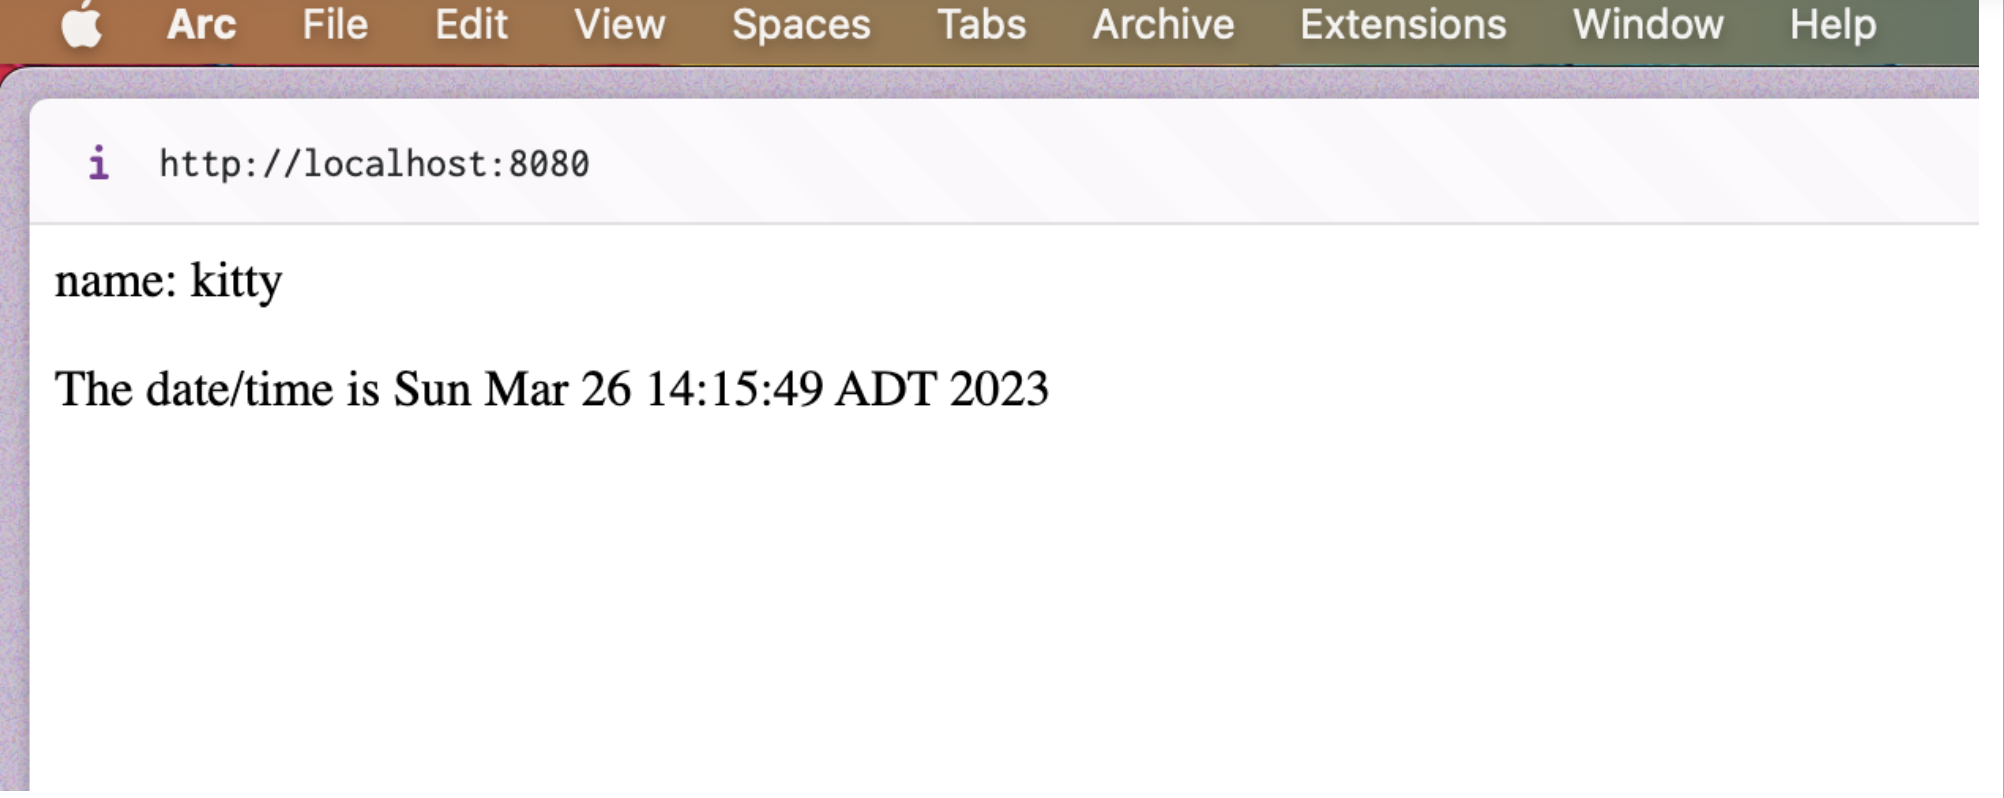

你肯定会好奇, 在上面jsp代码里, 我们只告诉了jsp我们的类名`test.Cat`, 那web容器是怎么根据这个信息找到这个类的? 

答案: 当然是通过classpath咯, 这个项目用的是maven项目, maven项目查看classpath的方法在前面讲过, 大概是`008 maven & tomcat`, 你看了就知道怎么回事了, 如果不了解classpath, 就去前面的文章找, 大概是`005 classpath....`. 